# Detección de sequía mediante clusterización de imágenes satelitales

En esta parte del algoritmo, desarrollamos un modelo de aprendizaje no-supervisado, capaz de indicar cuales imágenes satelitales se relacionan al fenomeno de sequía. Inicialmente, probamos la extracción de características mediante la red pre-entrenada VGG19. Como sabemos, el modelo VGG19 es una red neuronal convolucional, que como su nombre lo indica, tiene un total de 19 capas. La red VGG19 toma como entrada una imagen RGB y devuelve una representación de esta imagen de tamaño $7 \times 7 \times 512$. Una vez que se obtiene el tensor de características para un conjunto de datos, se emplea un algoritmo de clusterización jerárquica para clasificar los datos en dos clases: *sequía* y *no sequía*. 

## Datos

Las base de consta de series de imágenes satelitales adquiridas para algunos cuerpos de agua ubicados en México. Para mostrar el funcionamiento del clasificador, empleamos imágenes correspondientes al lago Yuriria en Guanajuato. En esta serie de imágenes se puede observar como para distintos instantes, algunas características como el color, cambian cuando el área del cuerpo de agua disminuye. En seguida, se muestran algunas imágenes de esta serie. 

In [5]:
# Importar imágenes
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

/content
drive  sample_data


In [7]:
# Cambiamos de directorio al Drive
import os
os.chdir("drive/MyDrive/HackathonAiLab2021/Code/images")
!ls

HuastecaPotosina   LagoYuririaGto0     PresaLaPurisimaGto0
HuastecaPotosina2  LagoYuririaGto1     PresaMalpasoChiapas
LagoYuririaGto	   PresaLaPurisimaGto  sentinel2_2018_01_01.png


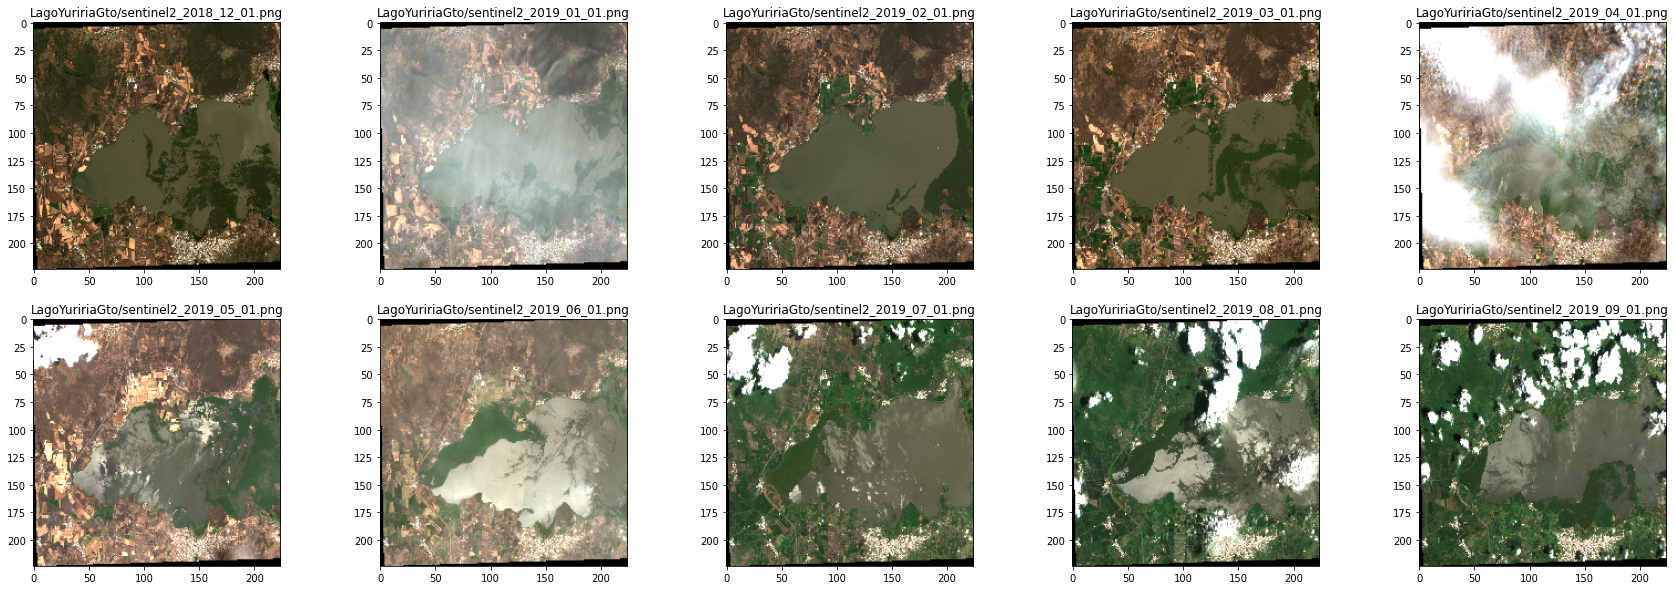

In [8]:
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Open some examples

img_path = glob(os.path.join('LagoYuririaGto', '*' + '.png'))

fig = plt.figure(figsize=(30, 10))
idx = 1

for path in img_path[:10]:
  img = image.load_img(path, target_size=(224, 224))
  fig.add_subplot(2, 5, idx)
  plt.imshow(img)
  plt.title(path)
  idx += 1
plt.show()

## Extracción de características con VGG19

Como se menciona anteriormente, se emplea la red pre-entrenada VGG19 para extracción de características. La base de datos, con la cual se entrenó este modelo, es nombrada ImageNet. Como paso previo a la extracción de características, se realiza un pre-procesamiento de las imágenes, ya que el entrenamiento se llevó a cabo sobre imágenes BGR normalizadas. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [10]:
# Define input 
input = Input(shape=(224, 224, 3), name='input')
# Features red
vgg19model = VGG19(include_top=False, weights='imagenet', input_tensor=input, input_shape=(224, 224, 3))

80150528/80134624 [==============================] - 1s 0us/step


In [11]:
# Preprocesamiento de imágenes
X = []

for path in img_path:
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  X.append(x)
X = np.asarray(X)
X = preprocess_input(X)

In [12]:
# Extracción de características
features = vgg19model.predict(X)

## Clusterización

Finalmente, se emplea un algoritmo de cluzterización jerárquica que utiliza la distancia euclidiana como métrica. Se espera que las imágenes donde se observa un grado de sequía, sean agrupadas en una clase.

In [13]:
from sklearn.cluster import AgglomerativeClustering  #Librería de agrupamiento

In [14]:
#flat features
Y = []

for ftr in features:
  aux_vector = np.reshape(ftr, -1)
  Y.append(aux_vector)

In [15]:
# Algoritmo de clusterización. Tenemos dos clases: sequía o no sequía
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=2e3, linkage='ward', affinity='euclidean').fit(np.asarray(Y))
#Obtenemos las etiquetas
labels = clustering.labels_

## Resultados

En la figura de abajo, se muestran los resultados obtenidos. Se observa que las imágenes donde la vegetación disminuye, son agrupadas. Así mismo, se puede notar que la clasificación es correcta aunque las imágenes contengan elementos como, nubes o niebla. Por otro lado, analizando el denograma, se puede advertir como, algunas características permiten asociar datos que pertenecen a la misma clase. Por ejemplo, algunas imágenes en *sequía*, comparten la característica de la niebla y aparecen como un grupo dentro la clase.

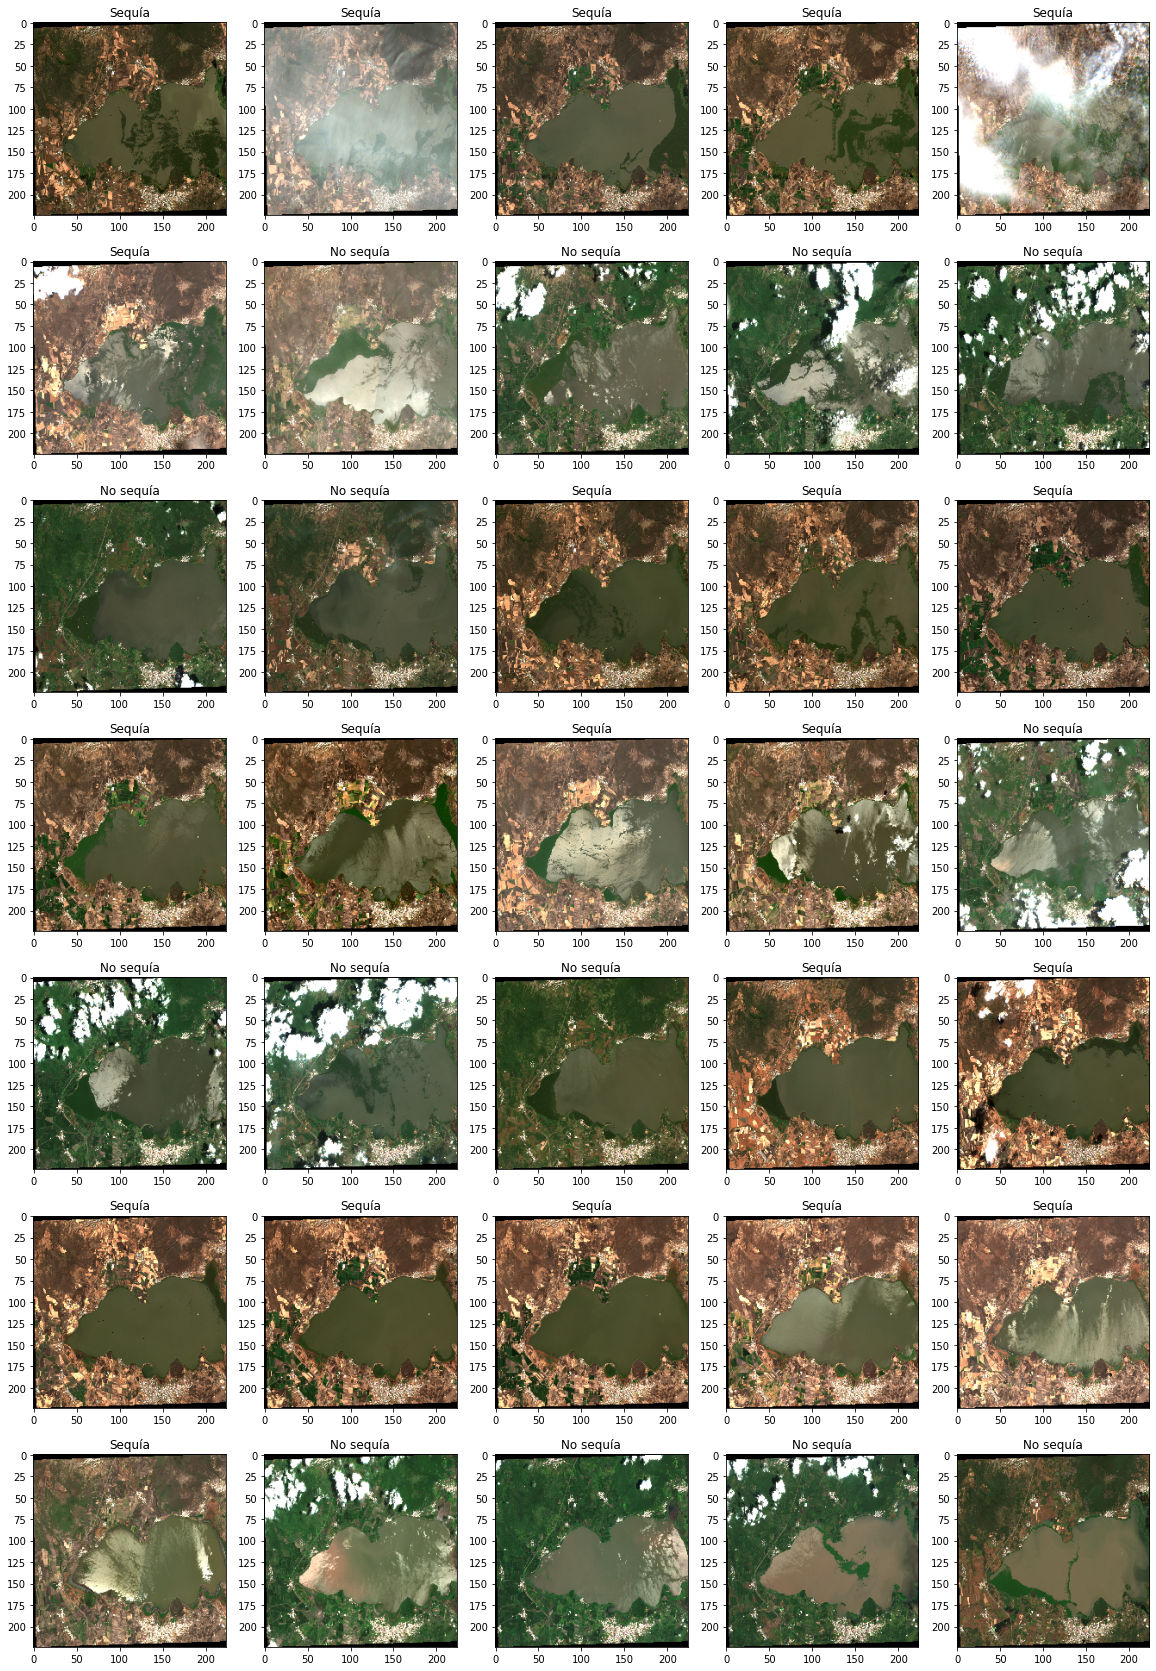

In [16]:
# Muestra resultados
fig = plt.figure(figsize=(20, 30))
columns = 5
rows = 7
for i in range(0, columns*rows):
    img = image.load_img(img_path[i], target_size=(224, 224))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    if labels[i] == 0:
      plt.title('Sequía')
    else:
      plt.title('No sequía')
plt.show()

### Dendrograma

In [17]:
from scipy.cluster.hierarchy import dendrogram

In [18]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [19]:
def graficarDendograma(model,title,figsize=(18,9),truncate_mode=None, p=None):
  fig = plt.figure(1, figsize=figsize)
  plt.title(title)
  plot_dendrogram(model, truncate_mode=truncate_mode, p=p)
  plt.show()

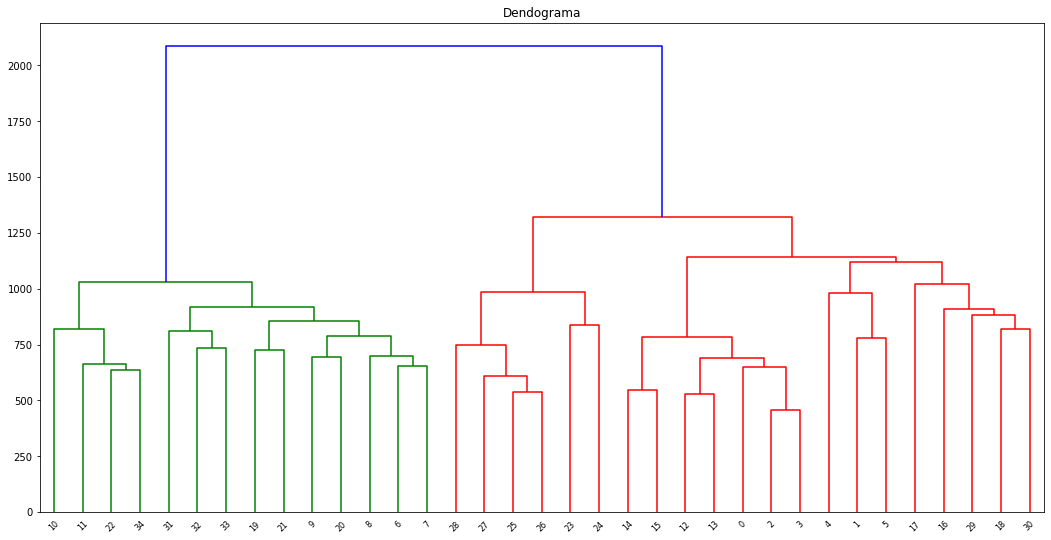

In [20]:
#Graficamos el dendograma
graficarDendograma(model=clustering, 
                   title="Dendograma",
                   truncate_mode=None, p=0)

## k-means

Otro algoritmo de clusterización es k-means. En este algoritmo también se utiliza la métrica de distancia. Como sabemos, en k-means un dato pertenece a un cluster, si la distancia al centroide de ese grupo, es menor que para los centriodes restantes. Una ventaja de emplear este algoritmo, es el tiempo de computo. En este último apartado se realiza un ejemplo de clasificación para datos fuera del conjunto de clusterización. En este caso, se calcula la distancia del vector de características de la imagen, a los centroides de cada clase. Finalmente, se considera que este dato pertenece al conjunto relacionado a la menor distancia euclidiana. 

In [21]:
from sklearn.cluster import KMeans

In [22]:
# Fit
kmeans = KMeans(n_clusters=2, random_state=0).fit(Y)

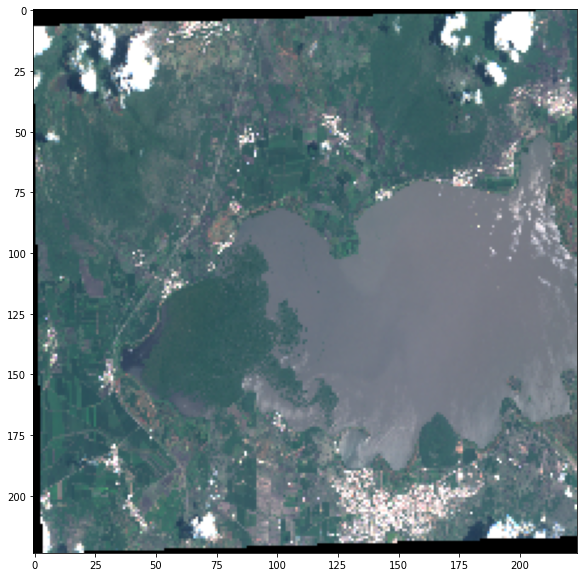

In [39]:
# Ejemplos
path_no_sequia = 'LagoYuririaGto1/sentinel2_2016_07_01.png'
im_no_sequia = image.load_img(path_no_sequia, target_size=(224, 224))
fig = plt.figure(figsize=(10, 10))
plt.imshow(im_no_sequia)
plt.show()

In [36]:
# Pre-process
im_no_sequia = image.img_to_array(im_no_sequia)
im_no_sequia = np.expand_dims(im_no_sequia, axis=0)
im_no_sequia = preprocess_input(im_no_sequia)
# Extracción de características
features_no_sequia = vgg19model.predict(im_no_sequia)

In [32]:
# Calcular ditancia a clusters
distance_cluster_0 = np.sqrt(np.mean(np.square(kmeans.cluster_centers_[0] - np.reshape(features_no_sequia, (-1, 1)))))
distance_cluster_1 = np.sqrt(np.mean(np.square(kmeans.cluster_centers_[1] - np.reshape(features_no_sequia, (-1, 1)))))

In [38]:
# Clasificación por distancia a centroides
if distance_cluster_0 < distance_cluster_1:
  print('No sequía')
else:
  print('Sequia')

No sequía
